In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from PIL import Image
import os
import pickle
import random
from glob import glob
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import  img_to_array, load_img
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.optimizers import Adam

In [2]:
Dataset="data"
Data_Dir=os.listdir(Dataset)
print(Data_Dir)

['Mask', 'No Mask']


In [3]:
images=[]
labels=[]
img_size=128
num_classes=2
batch_size=32
epoch=30

In [4]:
for category in Data_Dir:
    folder_path=os.path.join(Dataset,category)
    for img in os.listdir(folder_path):
        img_path=os.path.join(folder_path,img)
        img=cv2.imread(img_path)
        
        try:
            #concerting image to grayscale
#             grayscale_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            
            #resizing the gray scaled images into 56x56 to keep size of the image consistent
            resized_img=cv2.resize(img,(img_size,img_size))
            images.append(resized_img)
            labels.append(category)
        except Exception as e:
            print('Exception: ',e)

In [5]:
images=np.array(images)/255.0
images=np.reshape(images,(images.shape[0],img_size,img_size,3))

In [6]:
#perform one hot encoding 

lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)
labels=np.array(labels)

(train_X, test_X, train_y, test_y)=train_test_split(images,labels,test_size=0.2,random_state=0)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(1318, 128, 128, 3) (330, 128, 128, 3) (1318, 2) (330, 2)


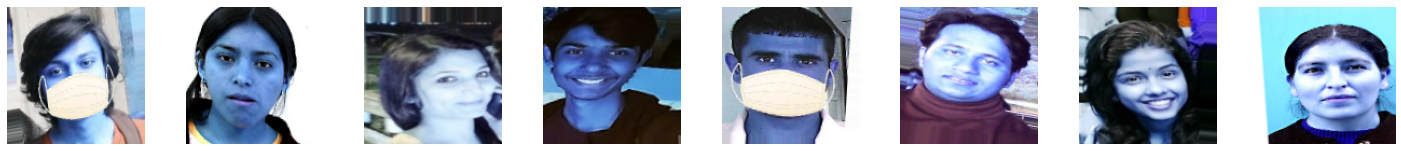

In [7]:
dataGen = ImageDataGenerator(width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            zoom_range = 0.2,
                            shear_range = 0.1,
                            rotation_range = 10)
dataGen.fit(train_X)
batches = dataGen.flow(train_X, train_y, batch_size = 32)
X_batch, y_batch = next(batches)

fig,axs = plt.subplots(1,8,figsize = (20,5))
fig.tight_layout()

for i in range(8):
    axs[i].imshow(X_batch[i].reshape(img_size,img_size,3))
    axs[i].axis('off')
plt.show()

# train_y = to_categorical(train_y, num_classes)
# test_y = to_categorical(test_y, num_classes)

In [8]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.densenet import DenseNet201
from keras.applications.densenet import  preprocess_input
from keras.preprocessing import image

In [9]:
model=Sequential()
model.add(Conv2D(64,(3,3),input_shape=(img_size,img_size,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 activation (Activation)     (None, 126, 126, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 activation_1 (Activation)   (None, 61, 61, 128)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                    

In [10]:
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=0.001),
             metrics=['accuracy'])

In [11]:
history=model.fit(
    train_X,
    train_y,
    epochs=epoch,
    validation_split=0.2)

model.save('cnn.h5')

Epoch 1/30
33/33 [==============================] - 6s 32ms/step - loss: 0.9564 - accuracy: 0.5503 - val_loss: 0.5362 - val_accuracy: 0.8106
Epoch 2/30
33/33 [==============================] - 1s 20ms/step - loss: 0.2966 - accuracy: 0.8871 - val_loss: 0.1235 - val_accuracy: 0.9621
Epoch 3/30
33/33 [==============================] - 1s 20ms/step - loss: 0.1726 - accuracy: 0.9307 - val_loss: 0.1419 - val_accuracy: 0.9659
Epoch 4/30
33/33 [==============================] - 1s 20ms/step - loss: 0.1193 - accuracy: 0.9564 - val_loss: 0.1436 - val_accuracy: 0.9356
Epoch 5/30
33/33 [==============================] - 1s 20ms/step - loss: 0.0960 - accuracy: 0.9639 - val_loss: 0.1206 - val_accuracy: 0.9697
Epoch 6/30
33/33 [==============================] - 1s 21ms/step - loss: 0.0838 - accuracy: 0.9696 - val_loss: 0.0857 - val_accuracy: 0.9697
Epoch 7/30
33/33 [==============================] - 1s 20ms/step - loss: 0.0676 - accuracy: 0.9725 - val_loss: 0.0837 - val_accuracy: 0.9735
Epoch 8/30
33

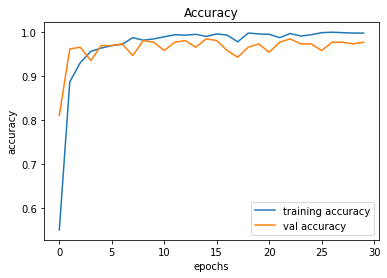

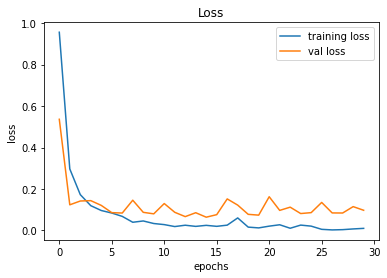

In [12]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [13]:
score = model.evaluate(train_X, train_y, verbose=0)
print('Train accuracy:', score[1])

Train accuracy: 0.9931714534759521


In [14]:
score = model.evaluate(test_X, test_y, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9575757384300232


In [15]:
pred = model.predict(test_X)

11/11 [==============================] - 0s 6ms/step


In [16]:
y_pred=[]

In [17]:
for i in range (len(pred)):
  y_pred.append(np.argmax(pred[i],axis=0))

In [18]:
y_pred

[1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,


In [19]:
from sklearn.metrics import accuracy_score
print(accuracy_score(np.where(test_y == 1)[1], y_pred))

0.9575757575757575


In [20]:
Data_Dir

['Mask', 'No Mask']

In [21]:
from sklearn.metrics import classification_report
cf = classification_report(np.where(test_y == 1)[1], y_pred, target_names = Data_Dir)
print(cf)

              precision    recall  f1-score   support

        Mask       0.95      0.97      0.96       171
     No Mask       0.97      0.94      0.96       159

    accuracy                           0.96       330
   macro avg       0.96      0.96      0.96       330
weighted avg       0.96      0.96      0.96       330



In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.where(test_y == 1)[1], y_pred)

In [23]:
cm_df = pd.DataFrame(cm, index = Data_Dir,
                     columns = Data_Dir
                    )

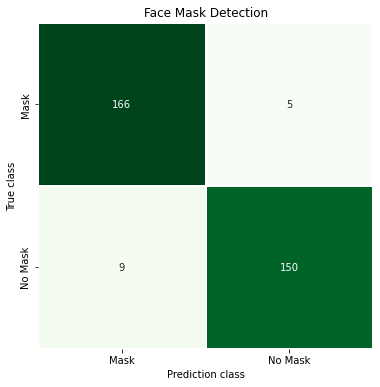

In [24]:
plt.figure(figsize = (6,6))
sns.heatmap(cm_df, annot = True,cmap='Greens',cbar=False,linewidth=2,fmt='d')
plt.title('Face Mask Detection')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()